In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

import os
from keras.applications.inception_resnet_v2 import InceptionResNetV2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Read input images and assign labels based on folder names
print(os.listdir("/content/drive/MyDrive/Project/projectdatasets"))

SIZE = 128  #Resize images

['test', 'train']


In [4]:
#Capture training data and labels into respective lists
train_images = []
train_labels = [] 

for directory_path in glob.glob("/content/drive/MyDrive/Project/projectdatasets/train/*"):
    label = directory_path.split("/")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*")):
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

#Convert lists to arrays        
train_images = np.array(train_images)
train_labels = np.array(train_labels)

Leukemia
Myeloma
Normal


In [5]:
train_images.shape

(4500, 128, 128, 3)

In [6]:
# Capture test/validation data and labels into respective lists

test_images = []
test_labels = [] 
for directory_path in glob.glob("/content/drive/MyDrive/Project/projectdatasets/test/*"):
    fruit_label = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(fruit_label)

#Convert lists to arrays                
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [7]:
test_images.shape

(1500, 128, 128, 3)

In [8]:
np.unique(train_labels)

array(['Leukemia', 'Myeloma', 'Normal'], dtype='<U8')

In [9]:
#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [10]:
print(np.unique(train_labels_encoded))

[0 1 2]


In [11]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [12]:
#Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

In [13]:
#Load model wothout classifier/fully connected layers
Irn_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in Irn_model.layers:
	layer.trainable = False
    
Irn_model.summary()  #Trainable parameters will be 0

219070464/219055592 [==============================] - 1s 0us/step
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 63, 63, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
             

In [14]:
#Now, let us use features from convolutional network for RF
feature_extractor = Irn_model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_training = features #This is our X input to RF

In [15]:
X_for_training.shape

(4500, 6144)

In [17]:
#decision tree
from sklearn import tree
model = tree.DecisionTreeClassifier()
model.fit(X_for_training, y_train) #For sklearn no one hot encoding


DecisionTreeClassifier()

In [18]:
#Send test data through same feature extractor process
X_test_feature = Irn_model.predict(x_test)
print(X_test_feature.shape)

(1500, 2, 2, 1536)


In [19]:
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

In [20]:
print(X_test_feature.shape)

(1500, 2, 2, 1536)


In [21]:
print(X_test_features.shape)

(1500, 6144)


In [22]:
#Now predict using the trained RF model. 
prediction = model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction = le.inverse_transform(prediction)

In [23]:
print(prediction)

['Leukemia' 'Normal' 'Leukemia' ... 'Myeloma' 'Myeloma' 'Myeloma']


In [24]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction))

Accuracy =  0.7453333333333333


**Precision Score , Recall Score , Accuracy Score , F1 Score**

In [25]:
#Precision Score
print("Precision = ", metrics.precision_score(test_labels, prediction,average='micro'))

#Recall
print("Recall = ", metrics.recall_score(test_labels, prediction,average='micro'))

#Accuracy Score
print("Accuracy = ", metrics.accuracy_score(test_labels, prediction))

#F1 score
print("F1 Score = ", metrics.f1_score(test_labels, prediction,average='micro'))

Precision =  0.7453333333333333
Recall =  0.7453333333333333
Accuracy =  0.7453333333333333
F1 Score =  0.7453333333333332


**Confusion Matrix**

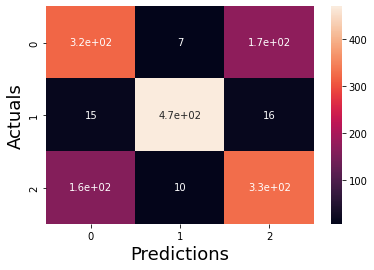

In [26]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_labels, prediction)
#print(cm)
sns.heatmap(cm, annot=True)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.show()

In [27]:
print(test_labels)

['Normal' 'Normal' 'Normal' ... 'Myeloma' 'Myeloma' 'Myeloma']


In [28]:
print(prediction)

['Leukemia' 'Normal' 'Leukemia' ... 'Myeloma' 'Myeloma' 'Myeloma']


In [29]:
cm = confusion_matrix(test_labels, prediction)
print(cm)

[[321   7 172]
 [ 15 469  16]
 [162  10 328]]


The prediction for this image is:  ['Normal']
The actual label for this image is:  Leukemia


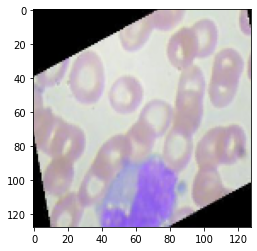

In [30]:
#Check results on a few select images
n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=Irn_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction = model.predict(input_img_features)[0]
prediction = le.inverse_transform([prediction])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction)
print("The actual label for this image is: ", test_labels[n])

In [31]:
from joblib import Parallel, delayed
import joblib
import pickle

In [33]:
# Save the model as a pickle in a file
pickle.dump(model, open('dt_Irn.pkl',"wb"))

In [34]:
model1 = pickle.load(open('dt_Irn.pkl',"rb"))

In [35]:
import shutil 
shutil.copy('/content/svm_Irn.pkl','/content/drive/MyDrive/Project/Colab Notebooks/New datasets/DecisionTree+Inception/75 25/dtIRN.h5')

'/content/drive/MyDrive/Project/Colab Notebooks/New datasets/DecisionTree+Inception/75 25/dtIRN.h5'